## First: import necessary modules

In [45]:
#imports

%matplotlib widget

# python core
import os
import datetime as dt

# python libraries
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# themachinethatgoesping modules
from themachinethatgoesping.echosounders import kongsbergall, simradraw # Filehandlers for kongsbergall and simradraw
from themachinethatgoesping.echosounders import index_functions         # Helper functions for finding echosounder files
from themachinethatgoesping import echosounders
from themachinethatgoesping import pingprocessing 
from themachinethatgoesping import tools as pingtools

In [46]:
# helper functions
close_plots = True
def create_figure(name: str, return_ax: bool = True):
    """Helper function to create a figure with a given name that returns the figure and axis
    """
    if close_plots:
        plt.close(name)
    fig = plt.figure(name)
    fig.suptitle = name

    if return_ax:
        return fig, fig.subplots()
    return fig

def set_ax_timeformat(ax, timeformat = "%d-%m-%Y %H:%M:%S"):
    if not hasattr(ax, '__iter__'):
        ax = [ax]
    
    for a in ax:
        a.xaxis.set_major_formatter(mdates.DateFormatter(timeformat))
        a.xaxis.set_major_locator(mdates.AutoDateLocator())
        a.tick_params(axis='x', rotation=30)

# 
def clear_memory():
    import gc
    gc.collect()
    
    import ctypes
    libc = ctypes.CDLL("libc.so.6") # clearing cache 
    libc.malloc_trim(0)

def get_ek80_pings(folders):
    # --- find all files ---
    files   = index_functions.find_files(folders, [".raw"])
    
    # --- init cache paths ---
    cache_paths = index_functions.get_cache_file_paths(files)
    
    # --- Load the data EK80 ---
    fm = simradraw.SimradRawFileHandler(files, file_cache_paths=cache_paths, init = False)
    fm.navigation_interface.set_min_gga_quality(4)
    fm.navigation_interface.init_from_file(file_cache_paths=cache_paths)
    fm.ping_interface.init_from_file(file_cache_paths=cache_paths)
    
    # change heave direction
    for p in tqdm(fm.get_pings(), delay =5):    
        s = p.get_sensor_data_latlon()
        s.heave = -s.heave
        p.set_sensor_data_latlon(s)
    
        c = p.get_sensor_configuration()
        c.set_depth_source("0",0,0,1.4)
        c.set_position_source("0",0,0,0)

    return fm.get_pings()

def get_em2040_pings(folders):
    # --- find all files ---
    files   = index_functions.find_files(folders, [".all", ".wcd"])
    
    # --- init cache paths ---
    cache_paths = index_functions.get_cache_file_paths(files)
    
    # --- Load the data EM2040 ---
    fm = kongsbergall.KongsbergAllFileHandler(files, file_cache_paths=cache_paths, init=False)
    
    # correct transducer offsets by 0.5m
    fm.configuration_interface.init_from_file(file_cache_paths=cache_paths)
    for c in fm.configuration_interface.per_file():
        s = c.read_sensor_configuration()
        for t in s.get_target_ids():
            if "TRX" in t:
                T = s.get_target(t)
                T.z += 0.5
                s.add_target(t, T)
    
        c.set_sensor_configuration(s)
    fm.ping_interface.init_from_file(file_cache_paths=cache_paths)

    return fm.get_pings()

## Open files from a survey

#### Find files (.raw and .all/.wcd)

In [3]:
# define a list of folder(s) to search for raw data files
# notes: 
#   - subdirectories will be searched as well
#   - you can add multiple folders by appending them to the list
#   - pair of files (e.g. .all and .wcd) don't have to be in the same folder
folders = []
folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Stations")
folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Transect")


#### Open ek80 data
- here we open the ek80 data using the helper function defined above
- we then imideately filter the pings to only include valid pings from the ES333 transducer


In [4]:
# open files in the specified folders and extract pings
ek80_pings = get_ek80_pings(folders)
print()
print(f'Initial pings: {len(ek80_pings)}')

#select only pings from the required transducer
channel_ids = ek80_pings.find_channel_ids()
for channel_id in channel_ids:
    if 'ES333' in channel_id:
        break
else:
    raise RuntimeError(f"Could not find channel id with 'ES333' in {channel_ids}")
ek80_pings = ek80_pings(channel_id)
print(f'Pings from channel {channel_id}: {len(ek80_pings)}')

ek80_pings = pingprocessing.filter_pings.by_features(ek80_pings, ['watercolumn'])
print(f'Pings with water column feature: {len(ek80_pings)}')

#clear_memory
clear_memory()

Found 659 files
indexing files ⠈ 99% :01s<00m:00s] [Found: 4033171 datagrams in 659 files (56889MB)]                                                 
Initializing SimradRawConfigurationDataInterface from file data ⠁ 100% :00s<00m:00s] [Done]            
Initializing SimradRawNavigationDataInterface from file data ⠠ 100% :00s<00m:00s] [Done]            
Initializing SimradRawPingDataInterface from file data ⠐ 99% :02s<00m:00s] [Done]                                              

Initial pings: 526981
Pings from channel WBT 400058-15 ES333-7C_ES: 105117
Pings with water column feature: 105117


In [5]:
# open files in the specified folders and extract pings
em2040_pings = get_em2040_pings(folders)
print()
print(f'Initial pings: {len(em2040_pings)}')

#select only pings from the required transducer
channel_ids = em2040_pings.find_channel_ids()
if len(channel_ids) != 2:
    raise RuntimeError(f"Len of channel_ids should be 2! {channel_ids}")
    
em2040_trx1_pings = em2040_pings(channel_ids[0])
em2040_trx2_pings = em2040_pings(channel_ids[1])
print(f'Pings from channel {em2040_trx1_pings.find_channel_ids()[0]}: {len(em2040_trx1_pings)}')
print(f'Pings from channel {em2040_trx2_pings.find_channel_ids()[0]}: {len(em2040_trx2_pings)}')

em2040_trx1_pings = pingprocessing.filter_pings.by_features(em2040_trx1_pings, ['watercolumn'])
em2040_trx2_pings = pingprocessing.filter_pings.by_features(em2040_trx2_pings, ['watercolumn'])
print(f'Pings from channel {em2040_trx1_pings[0].get_channel_id()} with watercolumn: {len(em2040_trx1_pings)}')
print(f'Pings from channel {em2040_trx2_pings[0].get_channel_id()} with watercolumn: {len(em2040_trx2_pings)}')

#delete not used pings
del em2040_pings

#clear_memory
clear_memory()

Found 288 files
indexing files ⠈ 99% :01s<00m:00s] [Found: 5130471 datagrams in 288 files (25571MB)]                                                 
Initializing KongsbergAllConfigurationDataInterface from file data ⢀ 100% :00s<00m:00s] [Done]            
Initializing KongsbergAllNavigationDataInterface from file data ⠁ 100% :02s<00m:00s] [Done]            
Initializing KongsbergAllPingDataInterface from file data ⠈ 99% :04s<00m:00s] [Done]                                              

Initial pings: 210675
Pings from channel TRX-2004: 105340
Pings from channel TRX-2031: 105335
Pings from channel TRX-2004 with watercolumn: 105335
Pings from channel TRX-2031 with watercolumn: 105335


## Create echograms of the data

#### define echogram function

In [6]:
# arguments
pings = np.array(ek80_pings.copy())
#pings = pings[0:1000]
max_pings = 20000
min_time = None
max_time = None
verbose = True


In [199]:
linear_mean = True
pss = echosounders.pingtools.PingSampleSelector()
max_samples = 2000

class EchoPingParameters:
    def __init__(self, 
                 pings, 
                 max_pings   = 10000, 
                 max_samples = 2000,
                 min_time = None,
                 max_time = None, 
                 min_depth = None,
                 max_depth = None,
                 pss = echosounders.pingtools.PingSampleSelector(),
                 linear_mean = True,
                 verbose=True):
        
        echopingtimes, echopingnumbers = self.sample_ping_times(
            pings = pings,
            max_pings = max_pings,
            min_time = min_time,
            max_time = max_time,
            verbose = verbose)
        
        AV = []
        min_r = []
        max_r = []
        res_r = []
        min_d = []
        max_d = []
        bottom_d = []
        nrs = {}
        times = []
        
        nroff=0
        
        for NR,nr in enumerate(tqdm(np.unique(echopingnumbers))):
            if nr == -1:
                nroff += 1
                continue
                
            nrs[nr] = NR - nroff
            
            ping = pings[nr]
            
            sel = pss.apply_selection(ping.watercolumn)
            c = ping.watercolumn.get_sound_speed_at_transducer()
            z = ping.get_geolocation().z
            res_r.append(ping.watercolumn.get_sample_interval()*c*0.5)
            min_r.append(np.max(ping.watercolumn.get_first_sample_offset_per_beam()[sel.get_beam_numbers()])*res_r[-1])
            max_r.append(np.max(ping.watercolumn.get_number_of_samples_per_beam(sel))*res_r[-1] + min_r[-1])
            min_d.append(z + min_r[-1])
            max_d.append(z + max_r[-1])
            times.append(ping.get_timestamp())
        
            if ping.has_bottom():
                sel_bottom = pss.apply_selection(ping.bottom)
                #bd = np.nanmin(p.bottom.get_xyz(sel_bottom).z) + p.get_geolocation().z
                # this is incorrect
                bd = np.nanmin(ping.bottom.get_xyz(sel).z) + ping.get_geolocation().z
        
                bottom_d.append(bd)
            else:
                bottom_d.append(np.nan)
            
            av = ping.watercolumn.get_av()
            if av.shape[0] == 1:
                av = av[0]
            else:
                if linear_mean:
                    av = np.power(10,av*0.1)
        
                av = np.nanmean(av,axis=0)
        
                if linear_mean:
                    av = 10*np.log10(av)
        
            AV.append(av)

        self.AV    = AV
        self.min_d = np.array(min_d)
        self.max_d = np.array(max_d)
        self.res_r = np.array(res_r)
        self.min_r = np.array(min_r)
        self.max_r = np.array(min_r)
        self.bottom_d = np.array(bottom_d)
        self.times=np.array(times)
        self.echopingtimes = np.array(echopingtimes)
        self.echopingtimestep = self.echopingtimes[1] - self.echopingtimes[0]
        self.echopingnumbers = np.array(echopingnumbers)
        self.nrs = nrs
        self.depths = self.sample_image_depths(self.min_d, self.max_d, self.res_r, min_depth, max_depth, max_samples)
        #self.ranges = self.sample_image_depths(self.min_r, self.max_r, self.res_r, min_depth, max_depth, max_samples)
        self.range_step = self.depths[1] - self.depths[0]

    @staticmethod
    def sample_ping_times(pings, max_pings=10000, min_time=None, max_time=None, verbose=True):
        if min_time is None: min_time = pings[0].get_timestamp()
        if max_time is None: max_time = pings[-1].get_timestamp()

        min_time = np.nanmax([pings[0].get_timestamp(), min_time])
        max_time = np.nanmin([pings[-1].get_timestamp(), max_time])
        
        if verbose:
            print(f'- Min time  : {dt.datetime.fromtimestamp(min_time,dt.UTC)}\n- Max time  : {dt.datetime.fromtimestamp(max_time,dt.UTC)}\n- Diff {max_time-min_time}')
        
        # filter pings by time step
        #pings = pingprocessing.filter_pings.by_time(pings, min_time, max_time)
        
        if verbose:
            print(f' -Min time 2: {pings[0].get_datetime()}\n -Max time 2: {pings[-1].get_datetime()} ')
        
        # get ping_times
        echo_times = np.linspace(min_time,max_time,max_pings)
        ping_times = np.array([p.get_timestamp() for p in tqdm(pings, delay=2)])
        ping_numbers = np.array(list(range(len(pings))))
        
        delta_t = (echo_times[1]-echo_times[0])
        
        # get nearest neighbor for echo_times
        interplator = pingtools.vectorinterpolators.NearestInterpolator(ping_times,ping_numbers)
        echopingnumbers = np.array(interplator(echo_times)).astype(int)
        echopingtimes = ping_times[echopingnumbers]
        
        if verbose:
            print(f'- Min time 3: {dt.datetime.fromtimestamp(echopingtimes[0],dt.UTC)}\n- Max time 3: {dt.datetime.fromtimestamp(echopingtimes[-1],dt.UTC)}')
        
        # exclude all times where the time difference is larger than delta_t/2
        echopingdiffs = np.abs(echo_times - echopingtimes)
        excl = np.argwhere(echopingdiffs > delta_t/2)
        
        echopingtimes[excl]   = np.nan
        echopingnumbers[excl] = -1
        
        # remove duplicate numbers
        u, c = np.unique(echopingnumbers, return_counts=True)
        C = int(np.quantile(c,0.75,method='linear'))
    
        if C > 1:
            max_pings = int(max_pings/C)
    
            if max_pings > 0:
                print("MAX PINGS:", max_pings)
                return sample_ping_times(
                      pings = pings,
                      max_pings = max_pings,
                      min_time = min_time,
                      max_time = max_time,
                      verbose = verbose)
    
        return echo_times, echopingnumbers

    @staticmethod
    def sample_image_depths(min_d, max_d, res_r, min_depth, max_depth, max_samples = 5000):
        # filter 
        if min_depth is None: min_depth = np.nanquantile(min_d,0.25)/1.5        
        if max_depth is None: max_depth = np.nanquantile(max_d,0.75)*1.5
        min_resolution = np.nanquantile(res_r,0.25)/1.5
        
        min_d[min_d > min_depth] = min_depth
        max_d[max_d < max_depth] = max_depth
        res_r[res_r > min_resolution] = min_resolution
        
        res = np.nanmin(res_r)
        mind = np.nanmin(min_d)
        maxd = np.nanmin(max_d)
        
        depths = np.arange(mind, maxd + res, res)
        
        if len(depths) > max_samples:
            depths = np.linspace(mind, maxd, max_samples)
        
        return depths

    def build_image(self, use_range = False, use_datetime = True):
        image = np.empty((len(self.echopingnumbers),len(self.depths)))
        image.fill(np.nan)
        
        i_echo = []
        i_av   = []

        if use_range:
            min_d = self.min_r
            max_d = self.max_r
            depths = self.ranges
        else:
            min_d = self.min_d
            max_d = self.max_d
            depths = self.depths
        
        for i in tqdm(range(len(self.AV))):
            interpolator = pingtools.vectorinterpolators.LinearInterpolator([min_d[i],max_d[i]],[0,len(self.AV[i])])
            index_av = np.round(interpolator(depths)).astype(int)
            index_echo = np.array(range(len(depths)))
        
            index_echo = index_echo[index_av >= 0]
            index_av = index_av[index_av >= 0]
            
            i_echo.append(index_echo[index_av < len(self.AV[i])])
            i_av.append(index_av[index_av < len(self.AV[i])])
        
        for i,nr in enumerate(tqdm(self.echopingnumbers)):
            if nr == -1:
                continue
            NR = self.nrs[nr]
            
            index_echo = i_echo[NR]
            index_av = i_av[NR]
            image[i][index_echo] = self.AV[NR][index_av]

        extent = [
            self.echopingtimes[0]  - self.echopingtimestep*0.5,
            self.echopingtimes[-1] + self.echopingtimestep*0.5,
            depths[-1] + self.range_step*0.5,
            depths[0]  - self.range_step*0.5
        ]

        if use_datetime:
            extent[0] = dt.datetime.fromtimestamp(extent[0], dt.UTC)
            extent[1] = dt.datetime.fromtimestamp(extent[1], dt.UTC)
        
        return image, extent
        

In [200]:
echopingtimes, echopingnumbers = EchoPingParameters.sample_ping_times(
            pings = pings,
            max_pings = 3,
            #min_time = min_time_.timestamp(),
            #max_time = max_time_.timestamp(),
            verbose = verbose)

print()
for t,n in zip(echopingtimes, echopingnumbers):
    print(f"{n: <10}: {dt.datetime.fromtimestamp(t,dt.UTC)}")

- Min time  : 2023-04-19 18:14:52.459772+00:00
- Max time  : 2023-04-22 02:31:41.721282+00:00
- Diff 202609.26150989532
 -Min time 2: 2023-04-19 18:14:52.459772+00:00
 -Max time 2: 2023-04-22 02:31:41.721282+00:00 
- Min time 3: 2023-04-19 18:14:52.459772+00:00
- Max time 3: 2023-04-22 02:31:41.721282+00:00

0         : 2023-04-19 18:14:52.459772+00:00
32318     : 2023-04-20 22:23:17.090527+00:00
105116    : 2023-04-22 02:31:41.721282+00:00


In [201]:
echopingtimes, echopingnumbers = EchoPingParameters.sample_ping_times(
            pings = pings,
            max_pings = 3,
            min_time = min_time_.timestamp(),
            #max_time = max_time_.timestamp(),
            verbose = verbose)

print()
for t,n in zip(echopingtimes, echopingnumbers):
    print(f"{n: <10}: {dt.datetime.fromtimestamp(t,dt.UTC)}")

- Min time  : 2023-04-20 18:40:19.184288+00:00
- Max time  : 2023-04-22 02:31:41.721282+00:00
- Diff 114682.53699398041
 -Min time 2: 2023-04-19 18:14:52.459772+00:00
 -Max time 2: 2023-04-22 02:31:41.721282+00:00 
- Min time 3: 2023-04-20 18:44:51.344079+00:00
- Max time 3: 2023-04-22 02:31:41.721282+00:00

21505     : 2023-04-20 18:40:19.184288+00:00
62996     : 2023-04-21 10:36:00.452785+00:00
105116    : 2023-04-22 02:31:41.721282+00:00


- Min time  : 2023-04-19 18:14:52.459772+00:00
- Max time  : 2023-04-22 02:31:41.721282+00:00
- Diff 202609.26150989532
 -Min time 2: 2023-04-19 18:14:52.459772+00:00
 -Max time 2: 2023-04-22 02:31:41.721282+00:00 
- Min time 3: 2023-04-19 18:14:52.459772+00:00
- Max time 3: 2023-04-22 02:31:41.721282+00:00


  0%|          | 0/6314 [00:00<?, ?it/s]

  0%|          | 0/6313 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

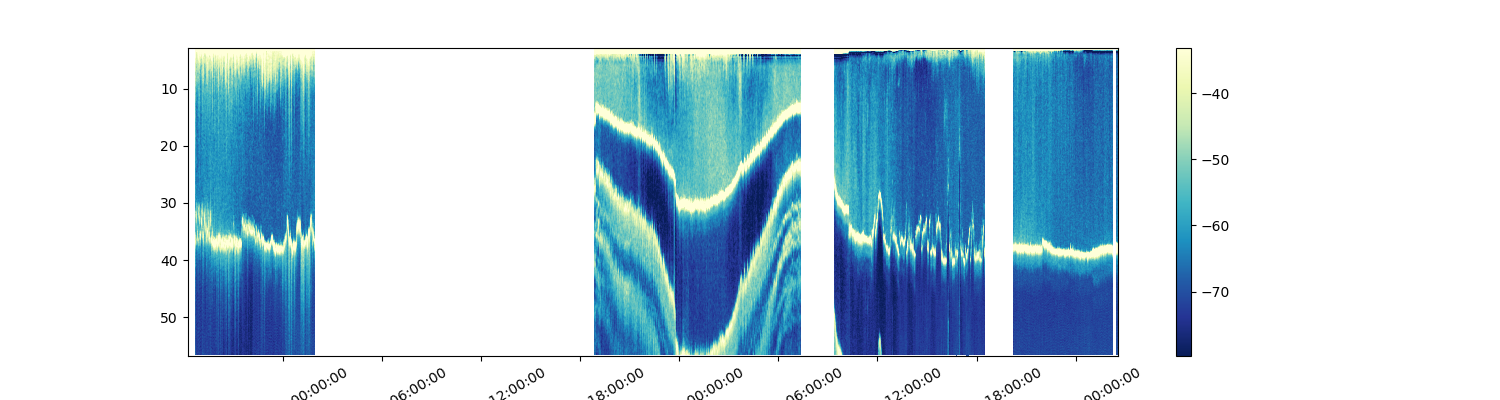

In [202]:
echoparam = EchoPingParameters( 
    pings, 
    max_pings   = 10000,
    max_samples = int(10000 * 4 / 15),
    min_time = None,
    max_time = None, 
    min_depth = None,
    max_depth = None,
    pss = echosounders.pingtools.PingSampleSelector(),
    linear_mean = True,
    verbose=True)

image, extent = echoparam.build_image(use_datetime = True)

vmin = np.nanquantile(image, 0.05)
vmax = np.nanquantile(image, 0.95)

fig,ax = create_figure('test')
mapable = ax.imshow(image.transpose(), extent = extent, aspect='auto', cmap='YlGnBu_r', vmin=vmin, vmax=vmax)
fig.colorbar(mapable,ax=ax)
fig.set_size_inches(15,4)
set_ax_timeformat(ax)

In [195]:
min_time_, max_time_ = mdates.num2date(ax.get_xlim())
print(min_time_)
print(max_time_)

max_depth_, min_depth_ = ax.get_ylim()
print(min_depth_, max_depth_)

2023-04-20 18:40:19.184288+00:00
2023-04-21 07:42:38.059435+00:00
3.4915721293965447 13.461103083445387


In [196]:
min_time_, max_time_ = mdates.num2date(ax.get_xlim())
print(min_time_)
print(max_time_)

echoparam_zoom = EchoPingParameters( 
    pings, 
    max_pings   = 10000,
    max_samples = int(10000 * 4 / 15),
    min_time = min_time_.timestamp(),
    max_time = max_time_.timestamp(), 
    min_depth = min_depth_,
    max_depth = max_depth_,
    pss = echosounders.pingtools.PingSampleSelector(),
    linear_mean = True,
    verbose=True)

image_zoom, extent_zoom = echoparam_zoom.build_image()

#vmin = np.nanquantile(image_zoom, 0.05)
#vmax = np.nanquantile(image_zoom, 0.95)

fig_zoom,ax_zoom = create_figure('zoom')
mapable = ax_zoom.imshow(image_zoom.transpose(), extent = extent_zoom, aspect='auto', cmap='YlGnBu_r', vmin=vmin, vmax=vmax)
fig_zoom.colorbar(mapable,ax=ax_zoom)
fig_zoom.set_size_inches(15,5)
set_ax_timeformat(ax_zoom)

#ax_zoom.set_xlim(min_time_, max_time_)
ax_zoom.set_ylim(max_depth_, min_depth_)

2023-04-20 18:40:19.184288+00:00
2023-04-21 07:42:38.059435+00:00
- Min time  : 2023-04-20 18:40:19.184288+00:00
- Max time  : 2023-04-21 07:42:38.059435+00:00
- Diff 46938.875146865845
 -Min time 2: 2023-04-19 18:14:52.459772+00:00
 -Max time 2: 2023-04-22 02:31:41.721282+00:00 
- Min time 3: 2023-04-20 18:44:51.344079+00:00
- Max time 3: 2023-04-21 07:25:23.608131+00:00


  0%|          | 0/9723 [00:00<?, ?it/s]

ValueError: zero-size array to reduction operation fmax which has no identity

In [198]:
echoparam_zoom.depths

array([ 4.36393642,  4.36987418,  4.37581194, ..., 19.67741882,
       19.68335658, 19.68929434])